# Drift dynamics in BOLD signals of working memory

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Wedge, Ellipse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import wilcoxon, pearsonr, spearmanr

from dynamic_bias import utils
from dynamic_bias.analyses.behavior import StimulusSpecificBias
from dynamic_bias.analyses.fmri import HemodynamicModel
utils.setup_matplotlib()

In [2]:
utils.download_dataset("data/outputs/behavior")
utils.download_dataset("data/outputs/fmri")

# load data
behavior = utils.load_behavior()
ssb_fits = utils.load(f"{utils.ORIGIN}/data/outputs/behavior/results_stimulus_specific_bias.pickle")

stim_boot = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/bootstrap_stimulus_conditioned.pickle')
ssb_perm = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/permutation_stimulus_specific_bias.pickle')
decision_boot = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/bootstrap_decision_conditioned.pickle')
decision_perm = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/permutation_decision_conditioned.pickle')
visual_params = utils.load(f"{utils.ORIGIN}/data/outputs/fmri/results_visual_drive.pickle")

ssb = StimulusSpecificBias()
dcbs = utils.load(f"{utils.ORIGIN}/data/outputs/fmri/results_decision_consistent_bias.pickle")
dcbs_boot = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/bootstrap_decision_consistent_bias_fixed_points.pickle')
dcbs_perm = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/permutation_decision_consistent_bias_fixed_points.pickle')
scores = utils.load(f'{utils.ORIGIN}/data/outputs/fmri/results_correspondence_score.pickle')

# hemodynamic model
hdt  = np.arange(4,28,step=2) # timing of interest
hdtv = np.arange(5,27,step=2) # timing of interest for visualizations
hdm  = HemodynamicModel(onset_hemodynamic=hdt[0])

downloading data/outputs/behavior...
data/outputs/behavior already exists. Skipping download...
downloading data/outputs/fmri...
data/outputs/fmri already exists. Skipping download...
downloading data/processed/behavior...
data/processed/behavior already exists. Skipping download...


---
## Stimulus specific bias dynamics

In [3]:
# avoid wrapping-around estimate SEM by computing errors and then taking their stats
stim_boot['early_err'] = utils.wrap( stim_boot['early'] - utils.exp_stim_list()[:, None], period=180. )
stim_boot['late_err']  = utils.wrap( stim_boot['late']  - utils.exp_stim_list()[:, None], period=180. )

earlym, earlys = utils.meanstats( stim_boot['early_err'], axis=0, sd=True )
latem,  lates  = utils.meanstats( stim_boot['late_err'],  axis=0, sd=True )

earlym = utils.wrap(earlym + utils.exp_stim_list()[:, None], period=180.) 
latem  = utils.wrap(latem  + utils.exp_stim_list()[:, None], period=180.)

# manual correction for wrapping-around orientations for visualization
for s in [11,12]:
    earlym[s][ earlym[s] < 0 ] += 180
    latem [s][ latem [s] < 0 ] += 180
    earlym[s] -= 180
latem[12] -= 180

# mid-time-point trajectory for visualization
earlym, earlys = [ hdm.interp(hdtv, hdt, traj) for traj in [earlym, earlys] ]
latem,  lates  = [ hdm.interp(hdtv, hdt, traj) for traj in [latem,  lates] ] 

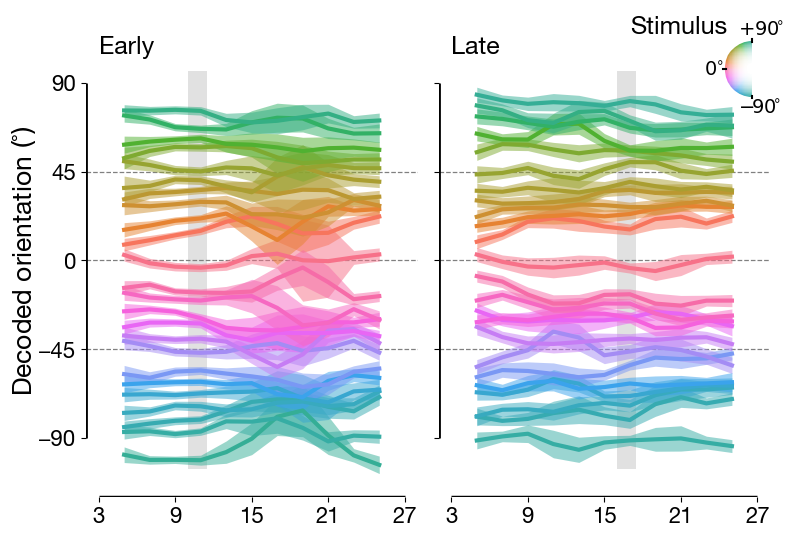

In [ ]:
f, ax = plt.subplots(1,2,sharey=True)
utils.set_size([6,4.2])

ax[0].axvspan(10,11.5,ymin=0.06,ymax=0.9,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,ymin=0.06,ymax=0.9,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i, (traj_m, traj_s) in enumerate( zip([earlym, latem], [earlys, lates]) ):
    for s in range(24):
        ax[i].fill_between(hdtv, traj_m[s]-traj_s[s], traj_m[s]+traj_s[s], 
                               color=utils.HUSL.colors[s], alpha=0.50, linewidth=0)
        ax[i].plot(hdtv, traj_m[s], color=utils.HUSL.colors[s], linewidth=3)
    ax[i].set_xlim([2,28])
    ax[i].set_ylim([-120,120])
    ax[i].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i].axhline(y=45,  color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i].axhline(y=-45, color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    utils.draw_publish_axis(ax[i], xrange=(3,27), yrange=(-90,90), 
                            xticks=[3,9,15,21,27], yticks=[-90,-45,0,45,90])

# Create inset
inset_ax = inset_axes(ax[1], width="25%", height="25%", bbox_to_anchor=(0.10, 0.05, 1, 1), bbox_transform=ax[1].transAxes)
                      
x, y, r = 0, 0, 1
re, im  = np.mgrid[-1:1:100j, -1:1:100j]
dist    = np.clip(np.sqrt(re**2 + im**2)**3, 0, 1)
angle   = np.angle(re + 1j*im)
angle   = np.mod(2.*angle, 2. * np.pi) - np.pi  # Wrap the angle to have two cycles
cmap    = LinearSegmentedColormap.from_list('', utils.HUSL.colors)
img     = plt.pcolormesh(re, im, -angle, shading='auto', cmap=cmap, alpha=dist)

wedge = Wedge(center=(x,y), r=r, theta1=90, theta2=270, width=0.8, clip_on=False, transform=inset_ax.transData)
img.set_clip_path(wedge)
inset_ax.use_sticky_edges = False
inset_ax.margins(x=0.05, y=0.05)
inset_ax.set_xlim([-1.5, 1.5])
inset_ax.set_ylim([-2.1, 2.1])

dd = 0.05
for ang in [np.pi/2., -np.pi/2., np.pi]:
    inset_ax.plot([np.cos(ang)*(1.-dd), np.cos(ang)*(1.+dd)], 
                  [np.sin(ang)*(1.-dd), np.sin(ang)*(1.+dd)], color='k', zorder=3)

ax[1].text(17,115, 'Stimulus', size=18)
inset_ax.text(np.cos(np.pi/2.)-0.50,  np.sin(np.pi/2.)+0.15, r'$+90\!\!^\circ$', size=14)
inset_ax.text(np.cos(np.pi)-0.70, np.sin(np.pi)-0.25, r'$\!\!0\!^\circ$', size=14)
inset_ax.text(np.cos(-np.pi/2.)-0.50, np.sin(-np.pi/2.)-0.6, r'$-\!90\!\!^\circ$', size=14)
inset_ax.axis('off')

if utils.LABEL:
    # f.text(0.5, 0.0, r"Time (s)", ha='center', va='center', fontsize=18)
    ax[0].set_ylabel(r"Decoded orientation $(\!\!^\circ\!\!)$", labelpad=0)    
    ax[0].text(3,105,'Early',fontsize=18)
    ax[1].text(3,105,'Late',fontsize=18)
    
plt.savefig(f'{utils.DIR_FIGURE}/fig5a.pdf',bbox_inches='tight', transparent=True)
plt.show()

In [5]:
earlym, earlys = utils.meanstats( ssb_perm['obs']['early'], axis=0 )
latem,  lates  = utils.meanstats( ssb_perm['obs']['late'],  axis=0 )

# permutation test (Bonferroni corrected)
earlyp = 0.05/12 > utils.permutation_test( earlym, ssb_perm['null']['early'] )
latep  = 0.05/12 > utils.permutation_test( latem,  ssb_perm['null']['late'] )

# mid-time-point trajectory for visualization
earlym, earlys = [ hdm.interp(hdtv, hdt, traj) for traj in [earlym, earlys] ]
latem,  lates  = [ hdm.interp(hdtv, hdt, traj) for traj in [latem,  lates] ] 

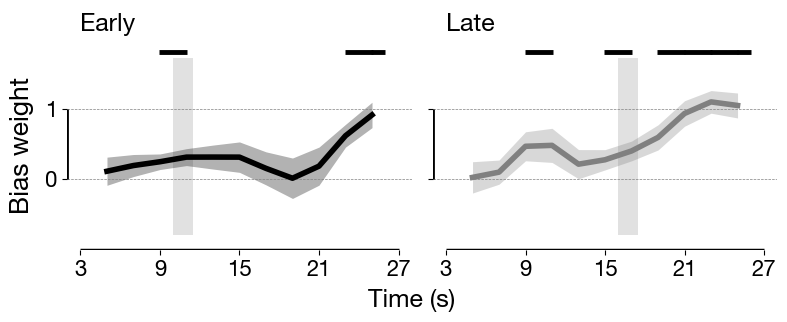

In [6]:
f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([6,2.4])

ax[0].axvspan(10,11.5,ymin=0.06,ymax=0.8,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,ymin=0.06,ymax=0.8,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i, (traj_m, traj_s, traj_p) in enumerate( zip([earlym, latem], [earlys, lates], [earlyp, latep]) ):
    color = ['k', 'gray'][i]
    ax[i].axhline(y=0, color='gray', linestyle='dashed', linewidth=0.5)
    ax[i].axhline(y=1, color='gray', linestyle='dashed', linewidth=0.5)
    ax[i].plot(hdtv, traj_m, linewidth=4, color=color)
    for t in np.where(traj_p)[0]:
        ax[i].hlines(1.8, xmin=max(hdt[t]-1.05, hdt[0]), xmax=min(hdt[t]+1.05, hdt[-1]), linewidth=3.5, color='k')
    ax[i].fill_between(hdtv, traj_m-traj_s, traj_m+traj_s, alpha=0.3, linewidth=0, color=color)
    ax[i].set_ylim([-1,2.4])
    ax[i].set_xlim([ 2, 28])
    utils.draw_publish_axis(ax[i], xrange=(3,27), yrange=(0,1), xticks=[3,9,15,21,27], yticks=[0,1])

if utils.LABEL:
    ax[0].text(3,2.1,'Early',fontsize=18)
    ax[1].text(3,2.1,'Late',fontsize=18)
    f.text(0.5, 0.0, r"Time (s)", ha='center', va='center', fontsize=18)
    ax[0].set_ylabel(r"Bias weight", labelpad=8, horizontalalignment='right', position=(1,0.72))

plt.savefig(f'{utils.DIR_FIGURE}/fig5b.pdf',bbox_inches='tight', transparent=True)
plt.show()

---
## Decision-consistent bias dynamics 

In [7]:
earlym, earlys = utils.meanstats( decision_boot['early'], axis=0, sd=True )
latem,  lates  = utils.meanstats( decision_boot['late'],  axis=0, sd=True )

# permutation test (Bonferroni corrected)
b = lambda x : -np.squeeze(np.diff(x, axis=-2)) / 2.
earlyp = 0.05/12 > utils.permutation_test( b(decision_perm['obs']['early']), b(decision_perm['null']['early']) )
latep  = 0.05/12 > utils.permutation_test( b(decision_perm['obs']['late'] ), b(decision_perm['null']['late'] ) )

# mid-time-point trajectory for visualization
earlym, earlys = [ hdm.interp(hdtv, hdt, traj) for traj in [earlym, earlys] ]
latem,  lates  = [ hdm.interp(hdtv, hdt, traj) for traj in [latem,  lates] ] 

In [8]:
# support line visualization
hdm = HemodynamicModel(onset_hemodynamic=hdt[0],
                       visual_params=visual_params)
hdtv_ = np.arange(3,28)

data_fit = {'stim'   : np.array([0, 0, 0, 0]),
            'ref'    : np.array([0, 0, 0, 0]),
            'choice' : np.array([1, 0, 1, 0]),
            't_dms'  : np.array([6, 6,12,12]),}
traj_fit = np.concatenate([decision_perm['obs']['early'], 
                           decision_perm['obs']['late']], axis=0)

hdm.fit(data = data_fit, traj = traj_fit, model='piecewise_linear')
hdm.calibrate(data_fit, traj_fit, hdt)

traj_pred = hdm.predict(data_fit, t_hemodynamic=hdtv_, model='piecewise_linear')
traj_pred = traj_pred.reshape((2,2,-1))

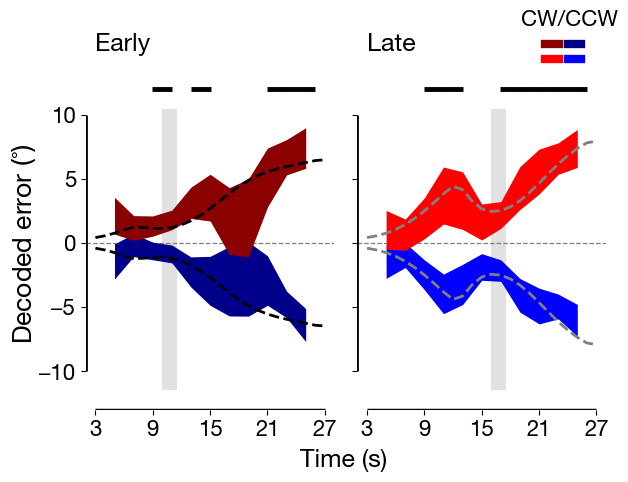

In [9]:
f, ax = plt.subplots(1,2, sharey=True)
utils.set_size([5,3.5])
ax[0].axvspan(10,11.5,ymin=0.06,ymax=0.9,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)
ax[1].axvspan(16,17.5,ymin=0.06,ymax=0.9,color='darkgrey',alpha=0.35,linewidth=0,zorder=-3)

for i, (traj_m, traj_s, traj_p, traj_r) in enumerate( zip([earlym, latem], 
                                                          [earlys, lates], 
                                                          [earlyp, latep],
                                                          traj_pred) ):

    red  = ['darkred','red'][i]
    blue = ['darkblue','blue'][i]
    ax[i].plot(hdtv_, traj_r[0], color=['k','gray'][i], linewidth=2, zorder=3, linestyle='dashed')
    ax[i].plot(hdtv_, traj_r[1], color=['k','gray'][i], linewidth=2, zorder=3, linestyle='dashed')

    ax[i].axhline(y=0,   color='gray', linestyle='dashed', linewidth=0.9, zorder=0)
    ax[i].fill_between(x=hdtv, y1=(traj_m-traj_s)[1], y2=(traj_m+traj_s)[1], color=blue, alpha=1, lw=0)
    ax[i].fill_between(x=hdtv, y1=(traj_m-traj_s)[0], y2=(traj_m+traj_s)[0], color=red,  alpha=1, lw=0)
    ax[i].set_ylim([-13,13])
    ax[i].set_xlim([2,28])

    for t in np.where(traj_p)[0]:
        ax[i].hlines(12, xmin=max(hdt[t]-1.05, hdt[0]), xmax=min(hdt[t]+1.05, hdt[-1]), linewidth=3.5, color='k')

    utils.draw_publish_axis(ax[i], xrange=(3,27), yrange=(-10,10), xticks=[3,9,15,21,27], yticks=[-10,-5,0,5,10])


# legend
from matplotlib.legend_handler import HandlerTuple
markerpar  = {'markeredgewidth': 2, 'markersize': 9, 'linestyle': '-', 'linewidth': 6}
line_red   = mlines.Line2D([], [], color='red', **markerpar)
line_blue  = mlines.Line2D([], [], color='blue', **markerpar)
line_dred  = mlines.Line2D([], [], color='darkred', **markerpar)
line_dblue = mlines.Line2D([], [], color='darkblue', **markerpar)

plt.legend([(line_dred,line_dblue), (line_red,line_blue)], ['', ''] ,
           handler_map={tuple: HandlerTuple(ndivide=None)},
           frameon=False, loc=(0.72, 0.99), fontsize=16, 
           handletextpad=0.8, handlelength=1.6, labelspacing=-0.22)
plt.text(0.90, 0.97, 'CW/CCW', ha='center', va='center', transform=f.transFigure, fontsize=16)

if utils.LABEL:
    ax[0].text(3,15,'Early',fontsize=18)
    ax[1].text(3,15,'Late',fontsize=18)
    f.text(0.55, 0.0, r"Time (s)", ha='center', va='center', fontsize=18)
    ax[0].set_ylabel(r"Decoded error $(\!\!^\circ\!\!)$", labelpad=0)
    
plt.tight_layout()
plt.savefig(f'{utils.DIR_FIGURE}/fig5c.pdf',bbox_inches='tight', transparent=True)
plt.show()

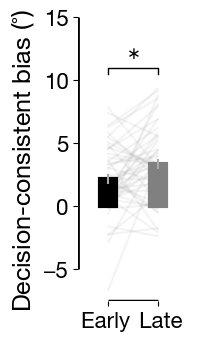

In [10]:
v_E = np.array(dcbs['b']['early'])
v_L = np.array(dcbs['b']['late'])

plt.figure()
ax = plt.gca()
utils.set_size([1.7,2.8])

xl, xr = -1, 1.5
for i in range(50):
    plt.plot([xl,xr], [v_E[i],v_L[i]], color='gray', alpha=0.09, zorder=-3)

m_e, s_e = utils.meanstats(v_E)
m_l, s_l = utils.meanstats(v_L)

bar = plt.bar(x=[xl,xr], height=[m_e,m_l], color=["black", "gray"])
bar[0].set_edgecolor('black')
bar[1].set_edgecolor('gray')
bar[0].set_linewidth(3)
bar[1].set_linewidth(3)
plt.errorbar(x=[xl,xr], y=[m_e,m_l], yerr=[s_e,s_l], fmt="none", color="darkgray")

ax.plot([xl, xl, xr, xr], [10.5, 11, 11, 10.5], lw=1, c='k')
ax.text((xl+xr)/2., 11.5, r"$ {\ast} $", ha='center', va='bottom', color='k', fontsize=12)
plt.xlim([-2.5,3])

if utils.LABEL:
    plt.ylabel(r"Decision-consistent bias $(\!\!^\circ\!\!)$", labelpad=5, fontsize=18)
    plt.xticks([xl,xr], ['Early ', ' Late'])

utils.draw_publish_axis(ax, xrange=(xl,xr), yrange=(-5,15), xticks=None, yticks=[-5,0,5,10,15])
plt.savefig(f'{utils.DIR_FIGURE}/fig5d.pdf',bbox_inches='tight', transparent=True)  
plt.show()

In [11]:
ttest  = DescrStatsW(v_L-v_E)
wilcox = wilcoxon(v_L-v_E)
print("Bias weight: Early vs. Late")
print('\nPaired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('\nWilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Bias weight: Early vs. Late

Paired samples t-test
t(49)= 2.4574200508404043 p= 0.017579863026990186
95% CI= (0.218640394312688, 2.1808125826591986)

Wilcoxon signed-rank test (without continuity correction)
V= 416.0 p= 0.03205348601661129


---
## Assay of biases before and after decision-making

In [12]:
regress_params = {
    k: v for k,v in zip(['c','p','s'], utils.simple_linregress(
        dcbs['d_bpre'], dcbs['d_bpost'],
        return_p_value=True, return_residual_variance=True
    ))
}

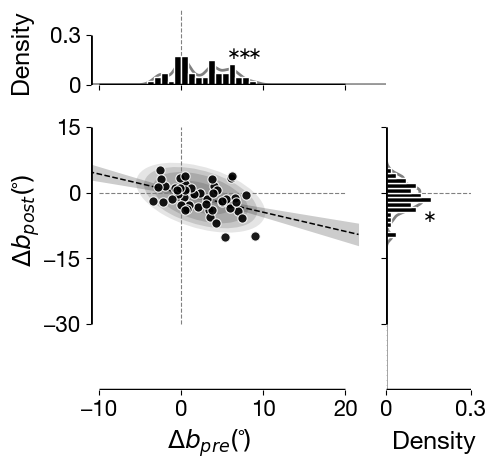

In [13]:
lim = 18
# xlim, ylim = 18, 45
xlim, ylim = 33, 45
f, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [3.5, 1], 'height_ratios': [1, 3.5], 'hspace' : 0.25, 'wspace' : 0})

utils.set_size([3.8, 3.8])

# main scatter plot
ax[1,0].vlines(x=0, ymin=-30, ymax=15, linestyle='dashed', color='gray', linewidth=0.8)
ax[1,0].hlines(y=0, xmin=-10,  xmax=20, linestyle='dashed', color='gray', linewidth=0.8)
ax[1,0].scatter(dcbs['d_bpre'], dcbs['d_bpost'], color='k', edgecolor='w', alpha=0.9, s=45, linewidth=0.8, zorder=3)

# plot regression line
x_line = np.linspace(-lim, lim * 1.2, 100)
y_line = regress_params['c']['intercept'] + x_line*regress_params['c']['slope']
s_line = utils.se_line(x_line, dcbs['d_bpre'], regress_params['s'])

ax[1,0].plot(x_line, y_line, color='k', linewidth=1.1, linestyle='dashed')
ax[1,0].fill_between(x_line, y_line - s_line, y_line + s_line, color='k', alpha=0.2, linewidth=0, zorder=-3)

# isoprobability ellipse
for prob, alph in zip( [0.95, 0.9, 0.8, 0.5], [0.2, 0.3, 0.4, 0.5] ):
    pnt, prm = utils.isoprob_ellipse(np.stack([dcbs['d_bpre'], dcbs['d_bpost']]).T, prob=prob)
    ax[1,0].add_patch(Ellipse(**prm, facecolor='gray', zorder=-5, alpha=alph, lw=0))

# ax[1,0].set_xlim([-xlim/3, xlim/1])
ax[1,0].set_xlim([-11, 25])
ax[1,0].set_ylim([-ylim/1, ylim/3])

# d_pre histogram on the top
ax[0,0].axvline(x=0, linestyle='dashed', color='gray', linewidth=0.8, zorder=-3)
ax[0,0].hist(dcbs['d_bpre'], bins=80, range=[-xlim, xlim], color='k', edgecolor='w', 
             orientation='vertical', density=True)
xvals = np.linspace(-xlim, xlim, 1000)
yvals = utils.kde1d(xvals, dcbs['d_bpre'], bw=0.2)
ax[0,0].plot(xvals, yvals, color='gray', zorder=-3, lw=2)
ax[0,0].set_ylim([0, 0.45])
# ax[0,0].set_xlim([-xlim/3, xlim/1])
ax[0,0].set_xlim([-11, 25])

# d_post histogram on the right
ax[1,1].axhline(y=0, linestyle='dashed', color='gray', linewidth=0.8, zorder=-3)
ax[1,1].hist(dcbs['d_bpost'], bins=80, range=[-ylim, ylim], color='k', edgecolor='w',
             orientation='horizontal', density=True)
xvals = np.linspace(-ylim, ylim, 1000)
yvals = utils.kde1d(xvals, dcbs['d_bpost'], bw=0.25)
ax[1,1].plot(yvals, xvals, color='gray', zorder=-3, lw=2)
ax[1,1].set_xlim([0, 0.3])
ax[1,1].set_ylim([-ylim/1, ylim/3])

ax[0,0].set_yticks([0,0.3])
ax[0,0].set_yticklabels(['0','0.3'])
ax[0,0].set_xticklabels([])
ax[1,1].set_xticks([0,0.3])
ax[1,1].set_xticklabels(['0','0.3'])
ax[1,1].set_yticklabels([])

utils.draw_publish_axis(ax[0,0], tight_layout=False, xrange=(-10,20), yrange=(0,0.3),  xticks=[-10,0,10,20], yticks=[0,0.3])
utils.draw_publish_axis(ax[1,0], tight_layout=False, xrange=(-10,20), yrange=(-30,15), xticks=[-10,0,10,20], yticks=[-30,-15,0,15])
utils.draw_publish_axis(ax[1,1], tight_layout=False, xrange=(0,0.3), yrange=(-30,15), xticks=[0,0.3],     yticks=[-30,-15,0,15])

# remove the empty top-right subplot
ax[0,1].axis('off')

if utils.LABEL:
    kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
    plt.text(-0.04,  0.72, 'Density', rotation=90, **kwargs)
    plt.text(-0.04,  0.38, r"$\Delta b_{post}(\!\!^\circ\!\!)$", rotation=90, **kwargs)
    plt.text( 0.28, -0.01, r"$\Delta b_{pre}(\!\!^\circ\!\!)$", **kwargs)
    plt.text( 0.74, -0.01, 'Density', **kwargs)
    
    kwargs = dict(fontsize=12, transform=plt.gcf().transFigure)
    plt.text( 0.40,  0.78, r"$ {\ast\!\!\ast\!\!\!\!\ast} $", **kwargs)
    plt.text( 0.80,  0.45, r"$ {\ast} $", **kwargs)

plt.savefig(f'{utils.DIR_FIGURE}/fig5e.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [14]:
spear = spearmanr(dcbs['d_bpre'],dcbs['d_bpost'])
pears = pearsonr(dcbs['d_bpre'],dcbs['d_bpost'])
pears_CI = utils.pearson_CI(dcbs['d_bpre'],dcbs['d_bpost'])
print('Behavior : Relation between d_bpre and d_bpost')
print('\nLinear regression')
print(f"Coefficient: {regress_params['c']['slope']}")
print(f"p-value: {regress_params['p']['slope']}")
print('\nCorrelation coefficient')
print('Pearson r=', pears[0], 'p=', pears[1])
print('Pearson CI=', pears_CI)
print('Spearman rho=', spear.correlation, 'p=', spear.pvalue)

print("\nΔb_pre vs. 0")
ttest  = DescrStatsW(dcbs['d_bpre'])
wilcox = wilcoxon(dcbs['d_bpre'])
print('One-sample t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

print("\nΔb_post vs. 0")
ttest  = DescrStatsW(dcbs['d_bpost'])
wilcox = wilcoxon(dcbs['d_bpost'])
print('One-sample t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Behavior : Relation between d_bpre and d_bpost

Linear regression
Coefficient: -0.43682782863048286
p-value: 0.001804088366476574

Correlation coefficient
Pearson r= -0.43050835245017977 p= 0.001804088366476568
Pearson CI= (-0.6330027118082839, -0.1728766145860955)
Spearman rho= -0.38823529411764707 p= 0.00533623298215236

Δb_pre vs. 0
One-sample t-test
t(49)= 5.22256391414848 p= 3.5906102623706004e-06
95% CI= (1.458977276448291, 3.284022363593711)
Wilcoxon signed-rank test (without continuity correction)
V= 201.0 p= 8.87296791773906e-06

Δb_post vs. 0
One-sample t-test
t(49)= -2.5431709915461163 p= 0.014192548019833483
95% CI= (-2.097690886947322, -0.24585577612279308)
Wilcoxon signed-rank test (without continuity correction)
V= 398.0 p= 0.020120643634562896


---
## Assay of biases around fixed points

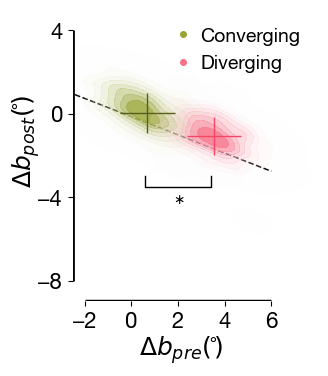

In [15]:
# colors
N_VIS = 500 # number of samples to visualize
cmps = {
    'converging' : utils.interp_colormap(color_u=utils.HUSL.colors[6]+(1,)),
    'diverging'  : utils.interp_colormap(color_u=utils.HUSL.colors[0]+(1,))
}

plt.figure()
ax = plt.gca()
utils.set_size([2.5, 2.8])

# plot KDE plots for 'converging' and 'diverging'
for i_cond, cond in enumerate(['converging', 'diverging']):
    dbpre_m,  dbpre_s  = utils.meanstats(dcbs_boot['d_bpre'][cond], median=True, sd=True)
    dbpost_m, dbpost_s = utils.meanstats(dcbs_boot['d_bpost'][cond], median=True, sd=True)

    # KDE plot for pre and post
    sns.kdeplot(x=dcbs_boot['d_bpre'][cond][:N_VIS], y=dcbs_boot['d_bpost'][cond][:N_VIS],
                cmap=cmps[cond], fill=True, thresh=0.001, levels=9)
    
    plt.vlines(dbpre_m, dbpost_m - dbpost_s, dbpost_m + dbpost_s,
               color=utils.lighten_color(cmps[cond].colors[-1], 1.3), linewidth=1)
    plt.hlines(dbpost_m, dbpre_m - dbpre_s, dbpre_m + dbpre_s,
               color=utils.lighten_color(cmps[cond].colors[-1], 1.3), linewidth=1)


# Add lines and labels for clarity
xl, xr = 0.6, 3.4
plt.plot([xl, xl, xr, xr], [-3, -3.5, -3.5, -3], lw=1, c='k')
plt.text((xl+xr)/2., -4.8, r"$\,^{\ast}$", ha='center', va='bottom', color='k', fontsize=14)

# #
kwargs = dict(marker='o', markersize=4, linestyle='None')
circ1 = mlines.Line2D([], [], color=cmps['converging'](1.0), label='Converging', **kwargs)
circ2 = mlines.Line2D([], [], color=cmps['diverging'](1.0),  label='Diverging', **kwargs)
plt.legend(handles=[circ1, circ2], frameon=False, loc='upper right', fontsize=14, handletextpad=-0.1)

#
lim = 5
x_line = np.linspace(-lim, lim * 1.2, 100)
y_line = regress_params['c']['intercept'] + x_line*regress_params['c']['slope']
plt.plot(x_line, y_line, color='k', linewidth=1.1, zorder=-3, linestyle='dashed')

plt.xlim([-2.5,8])
plt.ylim([-9,5])
utils.draw_publish_axis(ax, xrange=[-2,6], yrange=(-8,4), xticks=[-2,0,2,4,6], yticks=[-8,-4,0,4])

if utils.LABEL:
    kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
    plt.text(-0.02,  0.48, r"$\Delta b_{post}(\!\!^\circ\!\!)$", rotation=90, **kwargs)
    plt.text( 0.38, -0.01, r"$\Delta b_{pre}(\!\!^\circ\!\!)$", **kwargs)

plt.savefig(f'{utils.DIR_FIGURE}/fig5f.pdf', bbox_inches='tight', transparent=True)
plt.show()

In [16]:
print("diverging and converging when projected onto the regression line")

# projections on the regression line
proj_obs  = {}
proj_null = {}
for g in ['diverging', 'converging']:
    ## observation
    proj = np.stack([dcbs_perm['obs']['d_bpre'][g], dcbs_perm['obs']['d_bpost'][g]],axis=-1)
    proj_obs[g] = utils.project(proj, slope=regress_params['c']['slope'])

    ## null
    proj = np.stack([dcbs_perm['null']['d_bpre'][g], dcbs_perm['null']['d_bpost'][g]],axis=-1)
    proj_null[g] = utils.project(proj, slope=regress_params['c']['slope'])

print("\nProjected Euclidean distance between diverging and converging groups")
dist_obs = proj_obs['diverging'] - proj_obs['converging']
print('Distance:', np.linalg.norm(dist_obs))

print("\nBootstrap test: projected distance between diverging and converging groups (one-sided)")
dist_null = proj_null['diverging'] - proj_null['converging']
print('p-value:', utils.permutation_test(dist_obs[0,0], dist_null[:,0], alternative='greater'))

diverging and converging when projected onto the regression line

Projected Euclidean distance between diverging and converging groups
Distance: 3.0693383156280882

Bootstrap test: projected distance between diverging and converging groups (one-sided)
p-value: 0.0451


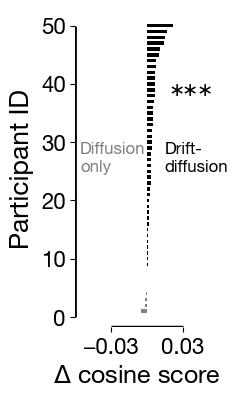

In [17]:
diff_cosines_score = np.subtract(
    [np.mean(v) for _,v in scores['full'].items()],
    [np.mean(v) for _,v in scores['reduced'].items()]
)

argsort = np.argsort(diff_cosines_score)
plt.figure()
utils.set_size([1.7,3])
ax = plt.gca()

colors = ['black' if val > 0 else 'gray' for val in diff_cosines_score[argsort]]
plt.barh(np.arange(1,51), (diff_cosines_score)[argsort], align='center', color=colors, height=0.6)
plt.xlim([-0.06,0.06])

plt.text(-0.056, 25, 'Diffusion\nonly', fontsize=12, color='gray')
plt.text(0.015, 25, 'Drift-\ndiffusion', fontsize=12)
plt.text(0.015, 38, r'$\,{\ast\!\!\ast\!\!\!\ast}$')

utils.draw_publish_axis(ax, xrange=(-0.03,0.03), yrange=(0,50), xticks=[-0.03,0.03], yticks=[0,10,20,30,40,50])

if utils.LABEL:
    kwargs = dict(fontsize=18, transform=plt.gcf().transFigure)
    plt.text( 0.15, -0.01, r'$\Delta$ cosine score', **kwargs)
    plt.ylabel(r'Participant ID')

plt.savefig(f'{utils.DIR_FIGURE}/fig5g.pdf',bbox_inches='tight', transparent=True)
plt.show()

In [18]:
ttest  = DescrStatsW(diff_cosines_score)
wilcox = wilcoxon(diff_cosines_score)
print('Paired samples t-test')
print('t(49)=',  ttest.ttest_mean()[0], 'p=', ttest.ttest_mean()[1])
print('95% CI=', ttest.tconfint_mean())
print('Wilcoxon signed-rank test (without continuity correction)')
print('V=', wilcox[0], 'p=', wilcox[1])

Paired samples t-test
t(49)= 6.206771508304693 p= 1.1226943763181423e-07
95% CI= (0.002927262064744803, 0.005730349157368822)
Wilcoxon signed-rank test (without continuity correction)
V= 67.0 p= 3.8819791825517314e-10
